In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print("TensorFlow version of this code is:",tf.__version__)

#  ------------------- Importing libraries ------------------
import numpy as np
import matplotlib.pyplot as plt

# -------- the code below is for uploading the data2D.npy or data100D.npy file to the code --------
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

TensorFlow 1.x selected.
TensorFlow version of this code is: 1.15.2


Saving data100D.npy to data100D.npy
User uploaded file "data100D.npy" with length 4000080 bytes


In [ ]:

# -------- the code below is for uploading the helper.py file to the code --------
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving helper.py to helper (1).py
User uploaded file "helper.py" with length 1289 bytes


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

In [ ]:
def distance_func(X, mu):
    """ Inputs:
            X: is an NxD matrix (N observations and D dimensions)
            mu: is an KxD matrix (K means and D dimensions)
        Outputs
            pair_dist: is the pairwise distance matrix (NxK)
    """
    global x_dummy, mu_dummy

    x_dummy = tf.expand_dims(x, 1)
    mu_dummy = tf.expand_dims(mu, 0)
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(x_dummy, mu_dummy)),2)
    
    return pair_dist


In [ ]:
def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """
    X_rank = tf.rank(X)
    d = tf.to_float(X_rank)
    sigma2 = tf.squeeze(sigma)
    dist = distance_func(X, mu)
    part1 = dist/(2*sigma2)
    part2 = tf.log(2 * np.pi * sigma2)
    part3 = -0.5 * d * part2
    log_PDF = part3 - part1
    
    return log_PDF

In [ ]:
def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    log_pi = tf.squeeze(log_pi)
    log_probability = tf.add(log_pi, log_PDF)
    log_sum = hlp.reduce_logsumexp(log_probability, keep_dims=True)

    result = log_probability - log_sum
    
    return result
    

In [ ]:
def MoG(x, mu, K, sigma, pi, log_pi, is_valid, data, iteration, option=0):

  global iter_mu, iter_log_pi, iter_sigma
  [num_pts, dim] = np.shape(data)

  if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]
    valid_losses = []

  losses = []

  log_PDF = log_gauss_pdf(x, mu, sigma)
  loss = - tf.reduce_sum(hlp.reduce_logsumexp(log_PDF + log_pi, 1, keep_dims=True))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

  prediction = tf.argmax(tf.nn.softmax(log_posterior(log_PDF, log_pi)),1)

  tf_init = tf.global_variables_initializer()
  sess = tf.Session()
  sess.run(tf_init)


  for iter in range(iteration):
    iter_mu, iter_loss, _, iter_pred, iter_log_pi, iter_sigma = sess.run([mu, loss, optimizer, prediction, log_pi, sigma], feed_dict={x:data})
    losses.append(iter_loss)

    if is_valid:
      iter_mu_valid, iter_loss_valid, _, _ = sess.run([mu, loss, optimizer, prediction], feed_dict={x:val_data})
      valid_losses.append(iter_loss_valid)
        
    if iter%100 == 0:
      print("K = ", K, ", Update #:", iter, "Loss value:", iter_loss)

  trainPercent = np.zeros(K)

  for i in range(K):
    trainPercent[i]=np.sum(np.equal(i, iter_pred))*100.0/len(iter_pred)

  if option==1:
    x1 = range(len(losses))
    y1 = losses
    plt.plot(x1,y1, label="Loss")
    plt.legend(loc="best")
    plt.title('Loss vs. Number of updates')
    plt.xlabel('Number of updates')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

  if option==2:
    k1 = len(iter_mu)
        
    for i in range(K):

      x4 = data[iter_pred == i, 0]
      y4 = data[iter_pred == i, 1]
      round_trainpercent = str(np.round_(trainPercent[i],decimals=2))+'%'
      plt.scatter(x4, y4, label=round_trainpercent)

    x5 = iter_mu[:, 0]
    y5 = iter_mu[:, 1]
    plt.scatter(x5, y5, marker='*', c="black")
    plt.legend(loc='upper center', bbox_to_anchor = (0.5,1.12), fancybox=True, ncol=K)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('K = '+str(K)+', Validation Loss = '+str(valid_losses[-1]), y=-0.23)
    plt.grid()
    plt.show()
  
  if option==3:
    plt.figure(1)

  #return losses
  return valid_losses



K =  5 , Update #: 0 Loss value: 132083.1
K =  5 , Update #: 100 Loss value: 45036.688
K =  5 , Update #: 200 Loss value: 45022.61
K =  10 , Update #: 0 Loss value: 221749.94
K =  10 , Update #: 100 Loss value: 44818.215
K =  10 , Update #: 200 Loss value: 44799.324
K =  15 , Update #: 0 Loss value: 104561.266
K =  15 , Update #: 100 Loss value: 45026.7
K =  15 , Update #: 200 Loss value: 44613.746
K =  20 , Update #: 0 Loss value: 179060.61
K =  20 , Update #: 100 Loss value: 44639.668
K =  20 , Update #: 200 Loss value: 44617.68
K =  30 , Update #: 0 Loss value: 95369.94
K =  30 , Update #: 100 Loss value: 45036.824
K =  30 , Update #: 200 Loss value: 45021.992


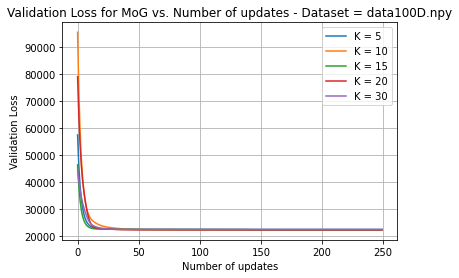

In [ ]:
if __name__ == "__main__":

      # Loading data
      #data = np.load('data2D.npy')
      data = np.load('data100D.npy')

      [N, D] = np.shape(data)
      
      # part 2.2.1:
      K = 3
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K, 1])))
      pi = tf.Variable(tf.random_normal([K, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      MoG(x, mu, K, sigma, pi, log_pi, False, data, 250, 1) 
      
      # part 2.2.2:
      K = 1
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K, 1])))
      pi = tf.Variable(tf.random_normal([K, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      MoG(x, mu, K, sigma, pi, log_pi, True, data, 250, 2) 
      
      K = 2
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K, 1])))
      pi = tf.Variable(tf.random_normal([K, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      MoG(x, mu, K, sigma, pi, log_pi, True, data, 250, 2) 
      
      K = 3
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K, 1])))
      pi = tf.Variable(tf.random_normal([K, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      MoG(x, mu, K, sigma, pi, log_pi, True, data, 250, 2)
      
      K = 4
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K, 1])))
      pi = tf.Variable(tf.random_normal([K, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      MoG(x, mu, K, sigma, pi, log_pi, True, data, 250, 2)
      
      K = 5
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K, 1])))
      pi = tf.Variable(tf.random_normal([K, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      MoG(x, mu, K, sigma, pi, log_pi, True, data, 250, 2)
      
      # part 2.2.3 (MoG):
      K5 = 5
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K5,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K5, 1])))
      pi = tf.Variable(tf.random_normal([K5, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      val_loss_5 = MoG(x, mu, K5, sigma, pi, log_pi, True, data, 250, 3) 
      
      K10 = 10
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K10,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K10, 1])))
      pi = tf.Variable(tf.random_normal([K10, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      val_loss_10 = MoG(x, mu, K10, sigma, pi, log_pi, True, data, 250, 3) 
      
      K15 = 15
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K15,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K15, 1])))
      pi = tf.Variable(tf.random_normal([K15, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      val_loss_15 = MoG(x, mu, K15, sigma, pi, log_pi, True, data, 250, 3)

      K20 = 20
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K20,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K20, 1])))
      pi = tf.Variable(tf.random_normal([K20, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      val_loss_20 = MoG(x, mu, K20, sigma, pi, log_pi, True, data, 250, 3)

      K30 = 30
      x = tf.placeholder("float", shape=[None, D])
      mu = tf.Variable(tf.truncated_normal([K30,D]))
      sigma = tf.exp(tf.Variable(tf.random_normal([K30, 1])))
      pi = tf.Variable(tf.random_normal([K30, 1]))              
      log_pi = tf.squeeze(hlp.logsoftmax(pi)) 
      val_loss_30 = MoG(x, mu, K30, sigma, pi, log_pi, True, data, 250, 3)


      plt.plot(range(len(val_loss_5)), val_loss_5, label="K = 5")
      plt.plot(range(len(val_loss_10)), val_loss_10, label="K = 10")
      plt.plot(range(len(val_loss_15)), val_loss_15, label="K = 15")
      plt.plot(range(len(val_loss_20)), val_loss_20, label="K = 20")
      plt.plot(range(len(val_loss_30)), val_loss_30, label="K = 30")
      plt.legend(loc="best")
      plt.title('Validation Loss for MoG vs. Number of updates - Dataset = data100D.npy')
      plt.xlabel('Number of updates')
      plt.ylabel('Validation Loss')
      plt.grid()
      plt.show()
      

In [ ]:
print("final valid loss for K = 5 => ", val_loss_5[-1])
print("final valid loss for K = 10 => ", val_loss_10[-1])
print("final valid loss for K = 15 => ", val_loss_15[-1])
print("final valid loss for K = 20 => ", val_loss_20[-1])
print("final valid loss for K = 30 => ", val_loss_30[-1])

final valid loss for K = 5 =>  22488.361
final valid loss for K = 10 =>  22373.994
final valid loss for K = 15 =>  22313.521
final valid loss for K = 20 =>  22315.8
final valid loss for K = 30 =>  22486.451
